In [1]:
%matplotlib inline

import os
os.chdir('/Users/Sinead/DC-project/')
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import script

import plotly 
plotly.offline.init_notebook_mode()

/Users/Sinead/anaconda/envs/project/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')
script.py:88: SyntaxWarning: import * only allowed at module level
  def pyheatmap(ArrayDicom, slice_, axis):


In [2]:
plt.ioff()

In [3]:
# PrePathDicom = '/Volumes/Backup Data/ASDH Samples/Sample1/Pre-operative/R-N11-109/HeadSpi  1.0  J40s  3'
PathDicom = '/Volumes/Backup Data/ASDH Samples/Sample1/Post-operative/R-N11-109/HeadSpi  1.0  J40s  3'
post_700_threshold=script.threshim(700,1500)
array, ConstPixelSpacing = script.vtk2np(post_700_threshold)

In [4]:
reshaped_array1 = np.zeros((220,512,229))

xp = np.linspace(0, ConstPixelSpacing[0]*512, 512)
x = np.linspace(0, 219, 220)

for j in range(512): # middle dimension
    for k in range(229): # last dimension
        reshaped_array1[:,j,k] = np.interp(x, xp, array[:,j,k])
            
reshaped_array2 = np.zeros((220,220,229))

for i in range(220): # first dimension
    for k in range(229): # last dimension
        reshaped_array2[i,:,k] = np.interp(x, xp, reshaped_array1[i,:,k])
        
reshaped_array3 = np.zeros((220,220,160))
xp = np.linspace(0, ConstPixelSpacing[2]*229, 229)
x = np.linspace(0, 159, 160)

for i in range(220): # first dimension
    for j in range(220): # middle dimension
        reshaped_array3[i,j,:] = np.interp(x, xp, reshaped_array2[i,j,:])
        
from scipy.ndimage.interpolation import rotate

angle1rad = 0.164067954932
angle2rad = 0.907180023618
angle1 = 9.40040137094 # degrees
angle2 = 51.9775866119 # degrees

rotated1 = rotate(reshaped_array3, angle1, mode='nearest', axes=(2,0))
rotated2 = rotate(reshaped_array3, angle2*(1-np.sin(angle1rad)), mode='nearest', axes=(0,1))

In [5]:
numpy_array=rotated2[:,:,100]
for i in range(numpy_array.shape[0]):
    for j in range(numpy_array.shape[1]):
        if abs(numpy_array[i,j])<0.01:
            numpy_array[i,j] = 0
indices = np.nonzero(numpy_array)
x = indices[1]
y = indices[0]
points = np.zeros((len(indices[1]),2))
for i in range(len(indices[1])):
    points[i, 0] = x[i]
    points[i, 1] = y[i]

In [6]:
import b2ac.preprocess
import b2ac.fit
import b2ac.conversion
print points
points, x_mean, y_mean = b2ac.preprocess.remove_mean_values(points)

# Fit using NumPy methods in double precision.
conic_numpy = b2ac.fit.fit_improved_B2AC_numpy(points)
# Fit using own written methods in double precision.
conic_double = b2ac.fit.fit_improved_B2AC_double(points)
# Fit using own written methods in 64-bit integer precision.
conic_int = b2ac.fit.fit_improved_B2AC_int(points)

# Convert from conic coefficient form to general ellipse form.
# general_form_numpy = b2ac.conversion.conic_to_general_1(conic_numpy)
# general_form_numpy[0][0] += x_mean
# general_form_numpy[0][1] += y_mean

general_form_double = b2ac.conversion.conic_to_general_1(conic_double)
general_form_double[0][0] += x_mean
general_form_double[0][1] += y_mean

# general_form_int = b2ac.conversion.conic_to_general_int(conic_int)
# general_form_int[0][0] += x_mean
# general_form_int[0][1] += y_mean

[[ 115.   76.]
 [ 116.   76.]
 [ 119.   76.]
 ..., 
 [ 143.  244.]
 [ 144.  244.]
 [ 146.  244.]]


148 158.687278243
86.1565339028 73.4407206712
1.4795723938 84.7732536487


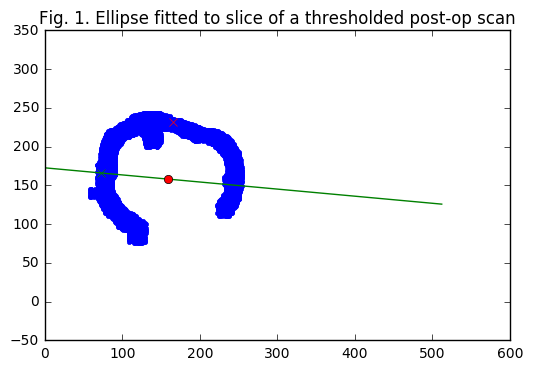

In [7]:
print x_mean, general_form_double[0][0]
xcentroid = general_form_double[0][0]
ycentroid = general_form_double[0][1]
xaxis = general_form_double[1][0]
yaxis = general_form_double[1][1]
angle = general_form_double[2] #anticlockwise is positive

y = np.linspace(0,1000)
x = np.linspace(0,1000)
x,y = np.meshgrid(x,y)
# plt.contour(x,y,(conic_double[0]*x**2 + conic_double[1]*x*y + conic_double[2]*y**2 + conic_double[3]*x + conic_double[4]*y + conic_double[5]),[0])
plt.plot(indices[1],indices[0], '.')
x = np.linspace(0,512)
y = ycentroid + (x-xcentroid)*np.tan(angle+np.pi/2)
plt.plot(x,y)
plt.plot(xcentroid, ycentroid, 'o')
if xaxis>yaxis:
    plt.plot(xcentroid+yaxis*np.cos(angle+np.pi/2),ycentroid+yaxis*np.sin(angle+np.pi/2),'x',color='red')
    plt.plot(xcentroid+xaxis*np.cos(angle),ycentroid+xaxis*np.sin(angle),'x', color='green')
else:
    plt.plot(xcentroid+xaxis*np.cos(angle),ycentroid+xaxis*np.sin(angle),'x',color='red')
    plt.plot(xcentroid+yaxis*np.cos(angle+np.pi/2),ycentroid+yaxis*np.sin(angle+np.pi/2),'x', color='green')
print yaxis, xaxis
print angle, angle/(2*np.pi)*360
plt.axis('equal')
plt.title('Fig. 1. Ellipse fitted to slice of a thresholded post-op scan')
plt.show()

In [8]:
reload(script)
from script import orientation
angles=np.zeros(rotated2.shape[2])
xcentroids=np.zeros(rotated2.shape[2])
ycentroids=np.zeros(rotated2.shape[2])
xmajor_axis_points=np.zeros(rotated2.shape[2])
ymajor_axis_points=np.zeros(rotated2.shape[2])

for i in range(rotated2.shape[2]):
    try:
        array_i=rotated2[:,:,i] # array to pass to 'orientation' must be thresholded already
        orientation_i=orientation(array_i)
        angles[i]=orientation_i[2] # pick out the angle
        xcentroids[i]=orientation_i[0][0]
        ycentroids[i]=orientation_i[0][1]
        xmajor_axis_points[i] = xcentroids[i]+orientation_i[1][1]*np.cos(angle)
        ymajor_axis_points[i] = ycentroids[i]+orientation_i[1][1]*np.sin(angle)
    except:
        pass

/Users/Sinead/anaconda/envs/project/lib/python2.7/site-packages/numpy/core/_methods.py:59: RuntimeWarning:

Mean of empty slice.

/Users/Sinead/anaconda/envs/project/lib/python2.7/site-packages/numpy/core/_methods.py:70: RuntimeWarning:

invalid value encountered in double_scalars



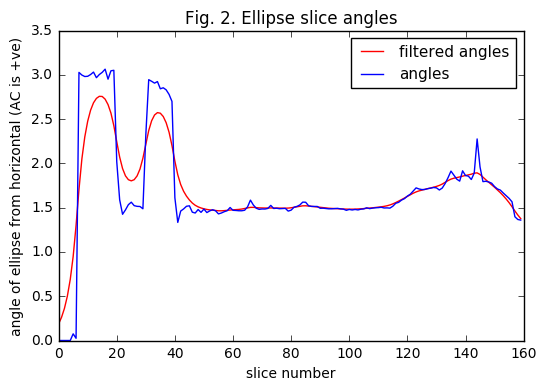

In [9]:
# make all angles positive
angles[angles < 0] += np.pi

import scipy.signal as signal
# First, design the Butterworth filter
N  = 1   # Filter order - the higher the order, the sharper the dropoff
pd = float(20)  # Cutoff period - the inverse is the cutoff frequency
fs = 1 # Sample rate frequency
nyq = 0.5*fs
low = 1/pd
wn = low/nyq # Cutoff frequency as a fraction
b, a = signal.butter(N, wn, output='ba')
filt_angles = signal.filtfilt(b,a, angles)
plt.plot(filt_angles,'r-',label='filtered angles')
plt.plot(angles,'b-', label = 'angles')
plt.xlabel('slice number')
plt.ylabel('angle of ellipse from horizontal (AC is +ve)')
plt.legend(fontsize=11)
plt.title('Fig. 2. Ellipse slice angles')
plt.show()

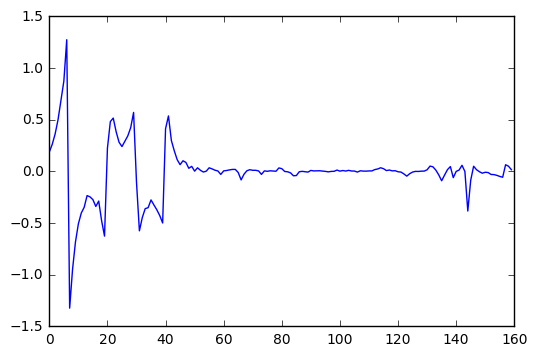

[[(65, 67)], [(130, 132)], [(134, 136)], [(138, 140)], [(140, 141)], [0], [(132, 133), (133, 134)], [(136, 137), (137, 138)], [(141, 143), (143, 147)], [0], [(48, 49), (49, 50), (50, 51), (51, 52), (52, 53), (53, 54), (54, 55), (55, 56), (56, 57), (57, 58), (58, 59), (59, 60), (60, 61), (61, 62), (62, 63), (63, 64), (64, 65)], [(67, 68), (68, 69), (69, 70), (70, 71), (71, 72), (72, 73), (73, 74), (74, 75), (75, 76), (76, 77), (77, 78), (78, 79), (79, 80), (80, 81), (81, 82), (82, 83), (83, 84), (84, 85), (85, 86), (86, 87), (87, 88), (88, 89), (89, 90), (90, 91), (91, 92), (92, 93), (93, 94), (94, 95), (95, 96), (96, 97), (97, 98), (98, 99), (99, 100), (100, 101), (101, 102), (102, 103), (103, 104), (104, 105), (105, 106), (106, 107), (107, 108), (108, 109), (109, 110), (110, 111), (111, 112), (112, 113), (113, 114), (114, 115), (115, 116), (116, 117), (117, 118), (118, 119), (119, 120), (120, 121), (121, 122), (122, 123), (123, 124), (124, 125), (125, 126), (126, 127), (127, 128), (12

[1.5298029296290947,
 1.493414811923452,
 1.4806565125085458,
 1.4849665314874014,
 1.4843935492107496,
 1.4911194286921032,
 1.5254104163371489,
 1.4904879231669594,
 1.4934625793740515,
 1.4877634374121878,
 1.4895938767578261,
 1.4918012113402488,
 1.4608704569540572,
 1.4718006965489114,
 1.5046324242130624,
 1.5140175611473932,
 1.5302148021577588,
 1.5622575624827972,
 1.560885219086261,
 1.5215827573184322,
 1.5138098588924462,
 1.5138985894483363,
 1.5132483685099538,
 1.4928637041605657,
 1.4938120674470774,
 1.4902227301406661,
 1.4864333344818179,
 1.4870298215839493,
 1.4890264936930933,
 1.4918573286450856,
 1.4858303681994329,
 1.4830029589656548,
 1.4698091890876774,
 1.4795723937984719,
 1.4736044392399028,
 1.4793982013728866,
 1.4741382516105073,
 1.4824370619645926,
 1.4855903472872425,
 1.4984678922166366,
 1.4887905805885502,
 1.4945775692659466,
 1.4985496137735084,
 1.500197647851341,
 1.5043730236442237,
 1.4963026905970536,
 1.4972636337791951,
 1.4947333405867

In [16]:
angles_diff = filt_angles-angles
plt.plot(angles_diff)
plt.show()

indices = [] # indices holds the slice range of interest
for i in range(len(angles)):
    if abs(angles_diff[i]) < 0.05:
        indices.append(i)
from itertools import groupby
z = zip(indices, indices[1:])
tmp = ([list(j) for i, j in groupby(z, key=lambda x: (x[1] - x[0]) <= 1)])
tmp = sorted(tmp, key=len) # longest lists at the end
for i in range(len(tmp)):
    if min(tmp[i])[0] <10:
        tmp[i] = [0]
    elif max(tmp[i])[1] > (len(angles)-10):
        tmp[i] = [0]
print tmp
tmp = sorted(tmp, key=len) # longest lists at the end
maxtmp = np.array(max(tmp, key=len))
maxindices = list(range(maxtmp[0][0], maxtmp[-1][-1]+1))



slices = maxindices
slice_angles = [angles[i] for i in slices]
slice_angles

In [17]:
head_angles = [angles[i] for i in slices]
head_x = [xcentroids[i] for i in slices] 
head_y = [ycentroids[i] for i in slices] 

mean_angle = np.mean(head_angles)
print mean_angle/(2*np.pi)*360

88.0357279848


In [12]:
import scipy.ndimage
# out = scipy.ndimage.interpolation.rotate(rotated2post_700,0,axes=(1,0), reshape=True, mode = 'nearest')
out50 = scipy.ndimage.interpolation.rotate(rotated2,-mean_angle/(2*np.pi)*360,axes=(0,1), reshape=True, mode = 'nearest')

KeyboardInterrupt: 

In [ ]:
plt.imshow(rotated2[:,:,280])
plt.show()
plt.imshow(out50[:,:,280])
plt.show()

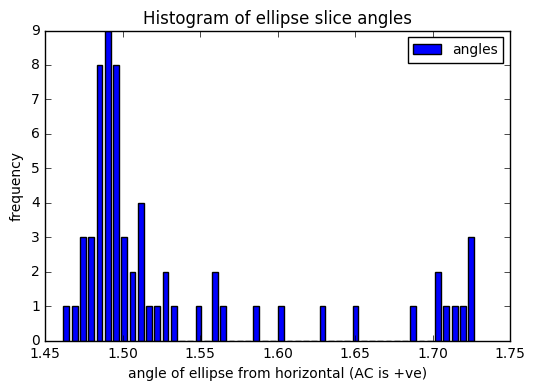

In [18]:
hist, bins = np.histogram(head_angles, bins=50)
width = 0.7 * (bins[1] - bins[0])
center = (bins[:-1] + bins[1:]) / 2
plt.bar(center, hist, align='center', width=width, label='angles')
plt.xlabel('angle of ellipse from horizontal (AC is +ve)')
plt.ylabel('frequency')
plt.legend(fontsize=10)
plt.title('Histogram of ellipse slice angles')
plt.show()


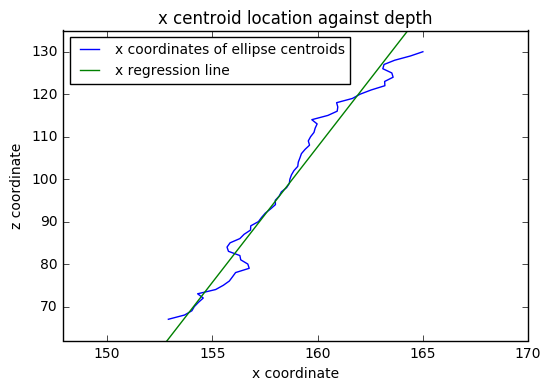

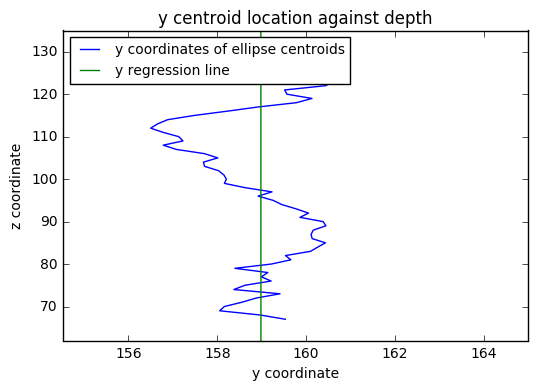

In [19]:
# find a plane
from scipy.optimize import curve_fit
def f(x, A, B): # this is your 'straight line' y=f(x)
    return A*x + B
A_x,B_x = curve_fit(f, slices, head_x)[0] # your data x, y to fit
A_y,B_y = curve_fit(f, slices, head_y)[0] # your data x, y to fit

# allow function to be horizonal or vertical by analysing least squared error

plt.plot(head_x, slices, label='x coordinates of ellipse centroids')
plt.plot(A_x*x + B_x, x, label='x regression line') 
plt.xlim(head_x[0]-5,head_x[-1]+5)
plt.ylim(slices[0]-5,slices[-1]+5)
plt.legend(fontsize=10, loc=2)
plt.xlabel('x coordinate')
plt.ylabel('z coordinate')
plt.title('x centroid location against depth')
plt.show()

plt.plot(head_y, slices, label='y coordinates of ellipse centroids')
plt.plot(A_y*x + B_y, x, label='y regression line') 
plt.xlim(head_y[0]-5,head_y[-1]+5)
plt.ylim(slices[0]-5,slices[-1]+5)
plt.legend(fontsize=10, loc=2)
plt.xlabel('y coordinate')
plt.ylabel('z coordinate')
plt.title('y centroid location against depth')
plt.show()

[[147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162 163 164
  165 166 167 168 169]
 [147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162 163 164
  165 166 167 168 169]
 [147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162 163 164
  165 166 167 168 169]
 [147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162 163 164
  165 166 167 168 169]
 [147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162 163 164
  165 166 167 168 169]
 [147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162 163 164
  165 166 167 168 169]
 [147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162 163 164
  165 166 167 168 169]
 [147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162 163 164
  165 166 167 168 169]
 [147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162 163 164
  165 166 167 168 169]
 [147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162 163 164
  165 166 167 168 169]]
[[154 154 154 154 154 154 154

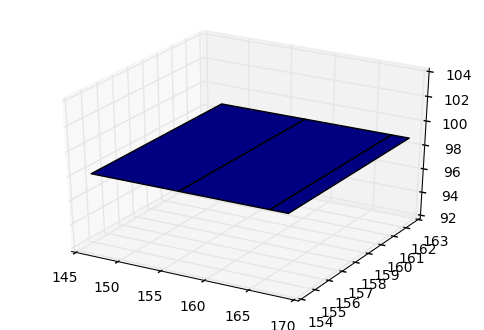

In [20]:
from mpl_toolkits.mplot3d import Axes3D
# Ax + B = z (for now) and Ay + B = z
z = np.median(slices)
x = A_x*z + B_x
y = A_y*z + B_y

# one vector of plane, v1
v1 = np.array([A_x, A_y, 1])
# second vector of plane, v2
v2 = np.array([np.cos(mean_angle+np.pi/2), np.sin(mean_angle+np.pi/2), 0])
# point that the plane goes through, p
p = np.array([x, y, z]) # coordinates when z = mean(indices)
normal = np.cross(v1,v2)
# a plane is ax+by+cz = d - find d
d = np.dot(p,normal)

xx = range(int(head_x[0])-5,int(head_x[-1])+5,1)
yy = range(int(head_y[0])-5,int(head_y[-1])+5,1)
[xx,yy] = np.meshgrid(xx,yy)
print xx
print yy
print normal
zz = (-normal[0]*xx-normal[1]*yy-d)*1./normal[2]

fig = plt.figure()
ax = fig.gca(projection='3d')
ax.plot_surface(xx, yy, z)
plt.show()


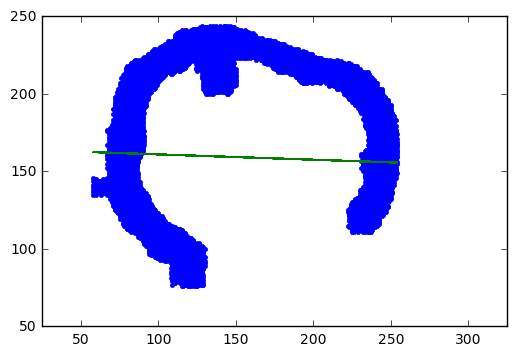

In [21]:
# superpose plane onto slices
a = normal[0]
b = normal[1]
c = normal[2]
# plane equation is ax+by+cz = d
# for each slice substitute slice number into z to get equation

slice_no = 100
numpy_array=rotated2[:,:,slice_no]
skull = np.nonzero(numpy_array)
x = skull[1]
y = skull[0]
plt.plot(x,y, '.')
plt.axis('equal')
plt.plot(x, (d-c*slice_no-a*x)/b)
plt.show()


In [22]:
array = rotated2

In [34]:
from plotly.graph_objs import *

slice_no = 140
slice_ = array[:,:,slice_no]


heatmap = Heatmap(
        z = slice_,
        colorscale = 'Greys'
        )

x = np.linspace(0,slice_.shape[0], 2)
y = (d-c*slice_no-a*x)/b

midline = Scatter(
    x = x,
    y = y,
    mode = 'lines'
)

layout = Layout(
    width = 600,
    height= 600,
    title='Fig. 3. Slice number %i' % slice_no
)
data = [heatmap, midline]
fig = Figure(data=data, layout=layout)
plotly.offline.iplot(fig)


In [ ]:
# plotly.offline.init_notebook_mode()
# from plotly.graph_objs import *

# for slice_no in range(140,162,2):
#     slice_ = array[:,:,slice_no]

#     heatmap = Heatmap(
#             z = slice_,
#             colorscale = 'Greys'
#             )

#     x = np.linspace(0,slice_.shape[0], 2)
#     y = (d-c*slice_no-a*x)/b

#     midline = Scatter(
#         x = x,
#         y = y,
#         mode = 'lines'
#     )

#     layout = Layout(
#         width = 600,
#         height= 600,
#         title='Slice number %i' % slice_no
#     )
#     data = [heatmap, midline]
#     fig = Figure(data=data, layout=layout)
#     plotly.plotly.image.save_as(fig, filename='{0}_smallrange.png'.format(slice_no))

# plotly.offline.iplot(fig)

In [ ]:
# to do
# write a function to find a plane of symmetry. optimise parameters using scipy optimise
# optimise x0, y0, z0, m, n where m is tilt and n is orientation
# send out email with meeting minutes